# Preamble

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import node_strength, ave_control, modal_control, consistency_thresh

In [3]:
exclude_str = 't1Exclude'
extra_str = '' # '_vol_norm' '_noboxcox' '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 200
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

### Setup output directory

In [4]:
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount


### Data processing options

In [5]:
threshold = True
vol_norm = False

## Load train/test .csv and setup node .csv

In [6]:
os.path.join(os.environ['TRTEDIR'])

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude'

In [7]:
# Load data
df = pd.read_csv(os.path.join(os.environ['TRTEDIR'], 'df_pheno.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1100, 43)


In [8]:
# Missing data file for this subject only for schaefer 200
if parc_scale == 200:
    df.drop(labels = (112598, 5161), inplace=True)

In [9]:
# output dataframe
vol_labels = ['vol_' + str(i) for i in range(num_parcels)]
str_labels = ['str_' + str(i) for i in range(num_parcels)]
ac_labels = ['ac_' + str(i) for i in range(num_parcels)]
mc_labels = ['mc_' + str(i) for i in range(num_parcels)]

df_node = pd.DataFrame(index = df.index, columns = vol_labels + str_labels + ac_labels + mc_labels)
# df_node.insert(0, 'nuisance_sample', df['nuisance_sample'])

print(df_node.shape)

(1099, 800)


## Load in cortical volume

In [10]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [11]:
VOL = np.zeros((df.shape[0], num_parcels))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['VOL_NAME_TMP'].replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(os.environ['VOLDIR'], file_name))
    if i == 0: print(full_path)    
    
    if len(full_path) > 0:
        img = nib.load(full_path[0])
        v = np.array(img.dataobj)
        v = v[v != 0]
        unique_elements, counts_elements = np.unique(v, return_counts=True)
        if len(unique_elements) == num_parcels:
            VOL[i,:] = counts_elements
        else:
            print(str(index) + '. Warning: not all parcels present')
            subj_filt[i] = True
    elif len(full_path) == 0:
        subj_filt[i] = True
    
df_node.loc[:,vol_labels] = VOL

['/Volumes/ResProjects_2TB/ResData/PNC/processedData/gm_vol_masks_native/81287/20100114x2738/Schaefer2018_200_17Networks_native_gm.nii.gz']


In [12]:
np.sum(subj_filt)

0

In [13]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]

## Load in structural connectivity matrices

In [14]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [15]:
A = np.zeros((num_parcels, num_parcels, df.shape[0]))
for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['SC_NAME_TMP'].replace("scanid", str(index[1]))
    file_name = file_name.replace("bblid", str(index[0]))
    full_path = glob.glob(os.path.join(os.environ['SCDIR'], file_name))
    if i == 0: print(full_path)
    if len(full_path) > 0:
        mat_contents = sio.loadmat(full_path[0])
        a = mat_contents[os.environ['CONN_STR']]
        A[:,:,i] = a
    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        A[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

['/Volumes/ResProjects_2TB/ResData/PNC/processedData/diffusion/deterministic_20171118/81287/20100114x2738/tractography/connectivity/81287_20100114x2738_SchaeferPNC_200_dti_streamlineCount_connectivity.mat']
82051/*x2856/tractography/connectivity/82051_*x2856_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87804/*x3144/tractography/connectivity/87804_*x3144_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
91332/*x3362/tractography/connectivity/91332_*x3362_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87990/*x3676/tractography/connectivity/87990_*x3676_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
103737/*x3964/tractography/connectivity/103737_*x3964_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87470/*x4000/tractography/connectivity/87470_*x4000_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
104161/*x4104/tractography/connectivity/104161_*x4104_SchaeferPNC_200_dti_streamlineCount_conne

In [16]:
np.sum(subj_filt)

19

In [17]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]
print(df_node.shape)

(1080, 800)


### Consistency thresholding

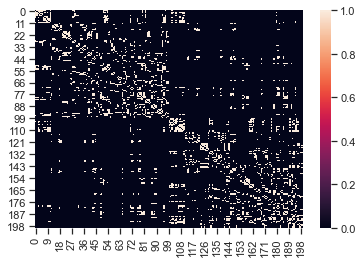

In [18]:
if threshold:
    A_out, A_mask = consistency_thresh(A, thresh = 0.6)
    sns.heatmap(A_mask)
else:
    print('skipping..')
    A_out = A.copy()

In [19]:
np.all(np.sum(A_mask[:,:], axis = 1) > 0)

True

### Check if any subjects have disconnected nodes in A matrix

In [20]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [21]:
for i in range(A_out.shape[2]):
    if np.any(np.sum(A_out[:,:,i], axis = 1) == 0):
        subj_filt[i] = True

In [22]:
np.sum(subj_filt)

18

In [23]:
if any(subj_filt):
    A_out = A_out[:,:,~subj_filt]
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]
print(df_node.shape)

(1062, 800)


### Get streamline count and network density

In [24]:
A_c = np.zeros((A_out.shape[2],))
A_d = np.zeros((A_out.shape[2],))
for i in range(A_out.shape[2]):
    A_c[i] = np.sum(np.triu(A_out[:,:,i]))
    A_d[i] = np.count_nonzero(np.triu(A_out[:,:,i]))/((A_out[:,:,i].shape[0]**2-A_out[:,:,i].shape[0])/2)
df.loc[:,'streamline_count'] = A_c
df.loc[:,'network_density'] = A_d

### Normalize A by regional volume

In [25]:
if vol_norm:
    vol_ref = os.path.join(os.environ['DERIVSDIR'], 'Schaefer2018_'+str(parc_scale)+'_17Networks_PNC_2mm.nii.gz')
    print(vol_ref)
    img = nib.load(vol_ref)
    v = np.array(img.dataobj)
    v = v[v != 0]
    unique_elements, counts_elements = np.unique(v, return_counts=True)

    for i in range(num_parcels):
        for j in range(num_parcels):
            denom = counts_elements[i] + counts_elements[j]
            A_out[i,j,:] = A_out[i,j,:]/denom
else:
    print('skipping..')

skipping..


### Compute node metrics

In [26]:
# fc stored as 3d matrix, subjects of 3rd dim
S = np.zeros((df.shape[0], num_parcels))
AC = np.zeros((df.shape[0], num_parcels))
MC = np.zeros((df.shape[0], num_parcels))

for (i, (index, row)) in enumerate(df.iterrows()):
    S[i,:] = node_strength(A_out[:,:,i])
    AC[i,:] = ave_control(A_out[:,:,i])
    MC[i,:] = modal_control(A_out[:,:,i])

df_node.loc[:,str_labels] = S
df_node.loc[:,ac_labels] = AC
df_node.loc[:,mc_labels] = MC

## Save out

In [27]:
df_node.isna().any().any()

False

In [28]:
os.environ['MODELDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount'

In [29]:
# Save out
np.save(os.path.join(os.environ['MODELDIR'], 'A'), A)
np.save(os.path.join(os.environ['MODELDIR'], 'A_out'), A_out)
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_base.csv'))
df.to_csv(os.path.join(os.environ['MODELDIR'], 'df_pheno.csv'))